0-3% Tranche (Last 6 Months):
    Day       Date  Spread
403  Fr 2024-05-03  19.022
404  Mo 2024-05-06  18.540
405  Tu 2024-05-07  18.506
406  We 2024-05-08  18.501
407  Th 2024-05-09  18.496

3-7% Tranche (Last 6 Months):
    Day       Date  Spread
419  Fr 2024-05-03   0.628
420  Mo 2024-05-06   0.501
421  Tu 2024-05-07   0.467
422  We 2024-05-08   0.478
423  Th 2024-05-09   0.475

7-15% Tranche (Last 6 Months):
    Day       Date  Spread
403  Fr 2024-05-03  -2.110
404  Mo 2024-05-06  -2.163
405  Tu 2024-05-07  -2.169
406  We 2024-05-08  -2.164
407  Th 2024-05-09  -2.163

15-100% Tranche (Last 6 Months):
    Day       Date  Spread
419  Fr 2024-05-03  -3.022
420  Mo 2024-05-06  -3.034
421  Tu 2024-05-07  -3.025
422  We 2024-05-08  -3.027
423  Th 2024-05-09  -3.018



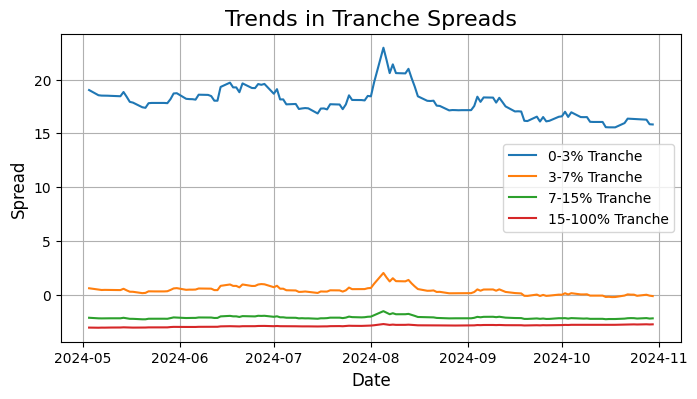

Tranche: 0-3%
  b_k: [0.01243794 0.01143794]

Tranche: 3-7%
  b_k: [0.00088912 0.00190844]

Tranche: 7-15%
  b_k: [0.00321162 0.00596162]

Tranche: 15-100%
  b_k: [0.00486708 0.00610727]



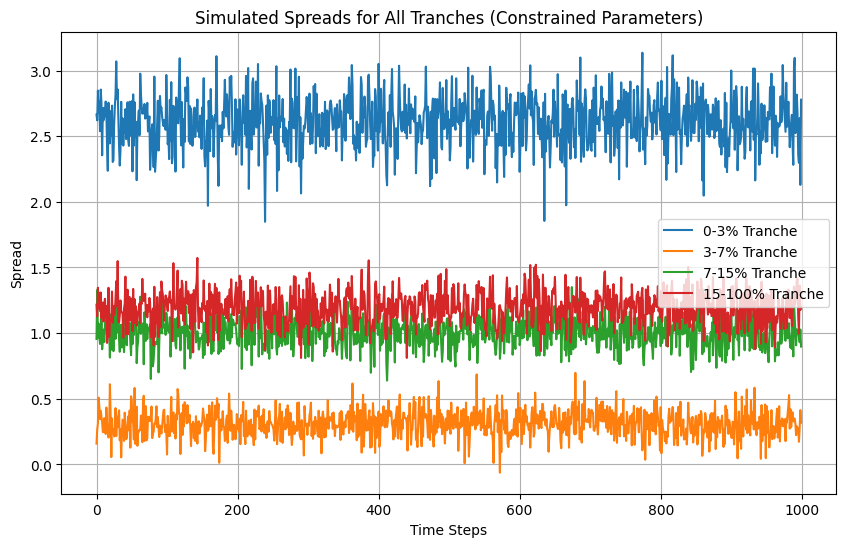

In [37]:
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import minimize, NonlinearConstraint, Bounds
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# Load the Excel file
excel_file = pd.ExcelFile('CDX.NA.IG39 Tranche data.xlsx')

tranche_data = {}
# Load each tranche sheet into a DataFrame
for sheet_name in excel_file.sheet_names:
    tranche_data[sheet_name] = excel_file.parse(sheet_name)

# Display basic information about each tranche sheet
tranche_summary = {
    sheet_name: {
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Column Names": df.columns.tolist(),
        "Sample Data": df.head().to_dict(orient="records")
    }
    for sheet_name, df in tranche_data.items()
}

def clean_tranche_data(df):
    df = df.copy()

    # Rename columns for clarity
    df.columns = ['Day', 'Date', 'Spread']
    
    # Drop rows with missing or invalid data
    df = df.dropna()
    
    # Ensure 'Date' is properly formatted as datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Drop rows where 'Date' could not be parsed
    df = df.dropna(subset=['Date'])
    
    # Ensure 'Spread' is numeric
    df['Spread'] = pd.to_numeric(df['Spread'], errors='coerce')
    
    # Drop rows with invalid 'Spread' values
    df = df.dropna(subset=['Spread'])
    
    # Sort by date
    df = df.sort_values(by='Date').reset_index(drop=True)
    
    return df

# Separate CDX_quote from tranche_data
cdx_quote_data = tranche_data.pop('CDX_quote')  # Extract CDX_quote

# Clean CDX_quote data (drop NaN rows, reset index, and rename columns if necessary)
cdx_quote_data_cleaned = clean_tranche_data(cdx_quote_data)

# Clean all tranche sheets
cleaned_tranche_data = {sheet_name: clean_tranche_data(df) for sheet_name, df in tranche_data.items()}

from datetime import timedelta

# Filter cleaned_tranche_data for the latest 6 months
filtered_tranche_data = {}

for tranche, data in cleaned_tranche_data.items():
    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Get the latest date in the tranche data
    latest_date = data['Date'].max()
    
    # Calculate cutoff date for the last 6 months
    cutoff_date = latest_date - timedelta(days=6 * 30)  # Approximation for 6 months
    
    # Filter data for the last 6 months
    filtered_data = data[data['Date'] >= cutoff_date]
    
    # Store the filtered data
    filtered_tranche_data[tranche] = filtered_data

# Display filtered data
for tranche, data in filtered_tranche_data.items():
    print(f"{tranche} Tranche (Last 6 Months):")
    print(data.head())
    print()

cleaned_tranche_data = filtered_tranche_data

# Function to visualize trends for all tranches on a single plot
def visualize_trends_together(cleaned_data):
    plt.figure(figsize=(8,4))
    
    # Plot trends for all tranches
    for tranche, data in cleaned_data.items():
        if 'Spread' in data.columns and 'Date' in data.columns:
            plt.plot(data['Date'], data['Spread'], label=f'{tranche} Tranche')
    
    # Add titles, labels, and legend
    plt.title('Trends in Tranche Spreads', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Spread', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize all cleaned tranche data trends together
visualize_trends_together(cleaned_tranche_data)

# Define parameters
n = 125  # Total number of entities in the portfolio
time_steps = 1000  # Simulating one year (252 trading days)

# Function to calculate pricing error for a given set of b_k coefficients
def pricing_error(b_k, spreads, attachment_points):
    """
    Calculate pricing error for a given set of b_k coefficients.
    Args:
        b_k (list): Coefficients to be calibrated.
        spreads (np.array): Observed tranche spreads.
        attachment_points (list): List of tranche attachment-detachment points.
    Returns:
        float: Sum of squared pricing errors.
    """
    n = 125  # Total number of entities in the portfolio (example)
    N_t = np.arange(len(b_k))  # Simulated number of defaults (example)
    
    # Calculate default intensity (lambda_t) using b_k
    lambda_t = np.array([
         (n - len(N_t)) * sum(b_k[:len(N_t)]) for _ in spreads
    ])
    
    # Error is the difference between simulated and observed spreads
    error = np.sum((lambda_t - spreads) ** 2)
    return error

# Attachment points for all tranches
attachment_points_dict = {
    '0-3%': [0, 0.03],
    '3-7%': [0.03, 0.07],
    '7-15%': [0.07, 0.15],
    '15-100%': [0.15, 1.00]
}

def adjust_spreads(spreads):
    offset = abs(min(spreads)) + 1 if min(spreads) <= 0 else 0
    return spreads + offset

def log_transform_spreads(spreads):
    return np.log(np.abs(spreads) + 1)  # Add 1 to avoid log(0)

def normalize_spreads(spreads):
    min_val = spreads.min()
    max_val = spreads.max()
    return (spreads - min_val) / (max_val - min_val)

def calibrate_all_tranches_with_adjustments(tranche_data, attachment_points_dict, transform_method='normalize'):
    """
    Calibrate the b_k for all tranches with spread adjustments.
    Args:
        tranche_data (dict): Dictionary of tranche names and their cleaned DataFrames.
        attachment_points_dict (dict): Dictionary of tranche names and attachment/detachment points.
        transform_method (str): Method to adjust spreads ('offset', 'log', 'normalize').
    Returns:
        dict: Calibration results with b_k for each tranche.
    """
    # Define transformation methods
    transform_methods = {
        'offset': adjust_spreads,
        'log': log_transform_spreads,
        'normalize': normalize_spreads
    }
    
    transform_func = transform_methods.get(transform_method, log_transform_spreads)
    results = {}
    
    for tranche_name, data in tranche_data.items():
        if 'Spread' in data.columns:
            spreads = data['Spread'].values
            
            # Adjust spreads based on the selected method
            normalized_spreads = transform_func(spreads)
            
            # Calibrate b_k
            attachment_points = attachment_points_dict.get(tranche_name, [0, 0.03])
            initial_b_k = [0.01] * len(attachment_points)
            result = minimize(pricing_error, x0=initial_b_k, args=(normalized_spreads, attachment_points), method='Nelder-Mead')
            calibrated_b_k = result.x
            
            # Store results
            results[tranche_name] = {
                'b_k': calibrated_b_k,
            }
    return results

# Example calibration using offset adjustment
calibration_results_adjusted = calibrate_all_tranches_with_adjustments(
    tranche_data=cleaned_tranche_data,
    attachment_points_dict=attachment_points_dict,
    transform_method='log'
)

# Display results
for tranche, result in calibration_results_adjusted.items():
    print(f"Tranche: {tranche}")
    print(f"  b_k: {result['b_k']}")
    print()

# Function to un-log transform parameters
def unlog_transform_parameters(calibrated_b_k):
    return np.exp(calibrated_b_k) - 1

# Function to simulate spreads using calibrated parameters with dynamic defaults
def simulate_spreads_with_defaults(calibrated_b_k, time_steps, n, N_t_simulated):
    simulated_spreads = []
    for t in range(time_steps):
        # Get the number of defaults at this time step
        num_defaults = N_t_simulated[t]
        
        # Calculate default intensity lambda_t using un-logged b_k
        lambda_t = (n - num_defaults) * np.sum(calibrated_b_k) * np.exp(-0.02 * num_defaults) + np.random.normal(0, 0.1)
        
        # Store the simulated spread for the time step
        simulated_spreads.append(lambda_t)
    return np.array(simulated_spreads)

# Un-log transform the calibrated parameters
unlogged_calibrated_b_k_dict = {tranche: unlog_transform_parameters(result['b_k']) for tranche, result in calibration_results_adjusted.items()}

# Simulate defaults dynamically for the given time steps
N_t_simulated = np.random.poisson(lam=5, size=1000)  # Simulate defaults dynamically

# Simulate spreads for each tranche using the dynamic default simulation
simulated_spreads_dict = {}
for tranche, calibrated_b_k in unlogged_calibrated_b_k_dict.items():
    simulated_spreads = simulate_spreads_with_defaults(calibrated_b_k, time_steps, n, N_t_simulated)
    simulated_spreads_dict[tranche] = simulated_spreads

# Plot simulated spreads for all tranches without smoothing
plt.figure(figsize=(10, 6))
for tranche, spreads in simulated_spreads_dict.items():
    plt.plot(range(time_steps), spreads, label=f'{tranche} Tranche')

plt.title('Simulated Spreads for All Tranches (Constrained Parameters)')
plt.xlabel('Time Steps')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()


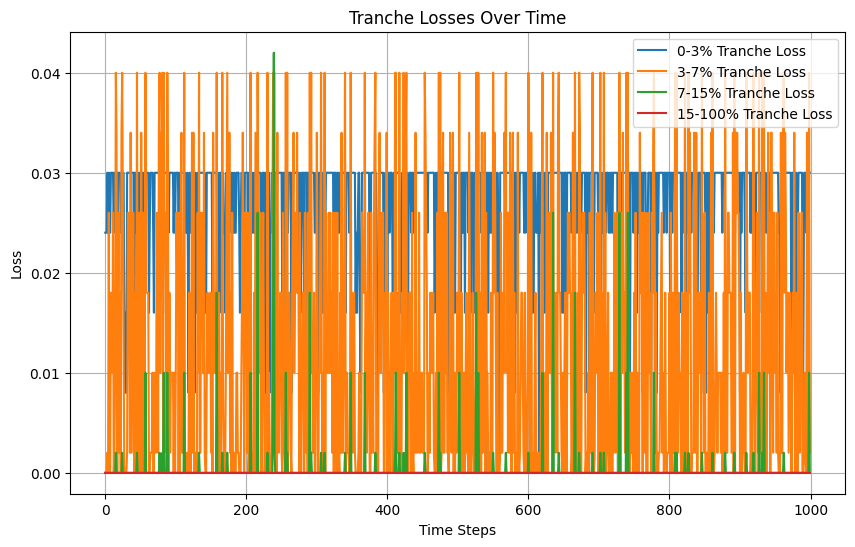

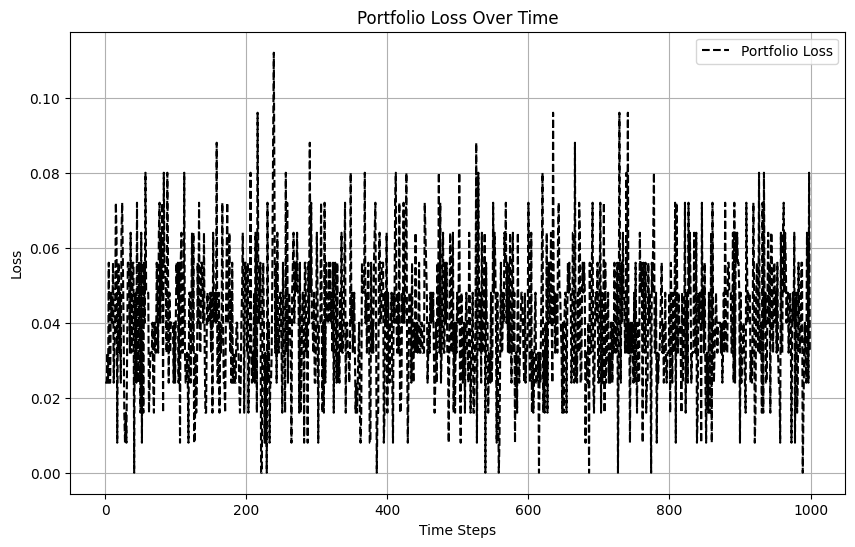

In [40]:
# Function to calculate tranche losses
def calculate_tranche_losses(N_t_simulated, attachment_points_dict, n):
    tranche_losses = {tranche: [] for tranche in attachment_points_dict}
    portfolio_losses = []
    
    for t in range(len(N_t_simulated)):
        num_defaults = N_t_simulated[t]
        portfolio_loss = num_defaults / n
        portfolio_losses.append(portfolio_loss)
        
        for tranche, (attachment, detachment) in attachment_points_dict.items():
            if portfolio_loss <= attachment:
                tranche_loss = 0
            elif portfolio_loss >= detachment:
                tranche_loss = detachment - attachment
            else:
                tranche_loss = portfolio_loss - attachment
            tranche_losses[tranche].append(tranche_loss)
    
    return tranche_losses, portfolio_losses

# Calculate tranche losses and portfolio loss
tranche_losses_dict, portfolio_losses = calculate_tranche_losses(N_t_simulated, attachment_points_dict, n)

# Plot tranche losses over time
plt.figure(figsize=(10, 6))
for tranche, losses in tranche_losses_dict.items():
    plt.plot(range(time_steps), losses, label=f'{tranche} Tranche Loss')

plt.title('Tranche Losses Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot portfolio loss over time
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps), portfolio_losses, label='Portfolio Loss', linestyle='--', color='black')
plt.title('Portfolio Loss Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# Function to calculate RMSE
def calculate_rmse(observed, simulated):
    min_length = min(len(observed), len(simulated))
    observed = observed[:min_length]
    simulated = simulated[:min_length]
    return np.sqrt(np.mean((observed - simulated) ** 2))

# Calculate RMSE for each tranche
for tranche, observed_spreads in cleaned_tranche_data.items():
    if 'Spread' in observed_spreads.columns:
        observed_spreads_values = observed_spreads['Spread'].values
        simulated_spreads_values = simulated_spreads_dict[tranche]
        rmse = calculate_rmse(observed_spreads_values, simulated_spreads_values)
        print(f"RMSE for {tranche} Tranche: {rmse}")

RMSE for 0-3% Tranche: 15.362318859595202
RMSE for 3-7% Tranche: 0.430799727261323
RMSE for 7-15% Tranche: 3.1014410477445495
RMSE for 15-100% Tranche: 4.05389799303346
